<a href="https://colab.research.google.com/github/ArnavSinghal1218/Computer-Vision-Final-Project/blob/main/Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion detection for facial expressions

In [23]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils import data
import pandas as pd
from PIL import Image
%matplotlib inline
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset,DataLoader, random_split
from torchvision import transforms
import torch.optim as optim
from torch import nn
from sklearn.model_selection import train_test_split

torch.manual_seed(123)

# Loading the dataset

In [24]:
df = pd.read_csv('fer2013.csv')

class FER2013Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Die Pixel-Spalte und Label-Spalte aus der CSV
        pixels = self.dataframe.iloc[idx, 1]
        label = int(self.dataframe.iloc[idx, 0])

        # Pixelwerte in 48x48 Bild umwandeln
        image = np.fromstring(pixels, sep=' ').reshape(48, 48).astype(np.uint8)

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformationen definieren
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Dataset erstellen
fer_dataset = FER2013Dataset(dataframe=df, transform=transform)

# Split in Training (80%), Validation (10%) und Test (10%) setzen
train_size = int(0.8 * len(fer_dataset))
val_size = int(0.1 * len(fer_dataset))
test_size = len(fer_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(fer_dataset, [train_size, val_size, test_size])

# DataLoader erstellen
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



Bilder: torch.Size([32, 1, 48, 48])
Labels: tensor([3, 6, 4, 3, 3, 5, 3, 0, 2, 4, 3, 3, 5, 2, 0, 0, 0, 6, 0, 0, 0, 4, 6, 4,
        6, 6, 3, 0, 6, 3, 5, 5])


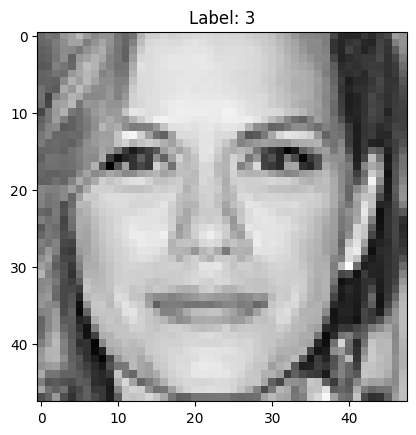

In [25]:
# Beispiel: Lade eine Batch aus dem Trainings-Loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Bilder: {images.shape}")
print(f"Labels: {labels}")

# Zeige ein Bild an
plt.imshow(images[0].squeeze(), cmap="gray")
plt.title(f"Label: {labels[0].item()}")
plt.show()

## Implementing the network

In [26]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 1. Convolutional Block (Conv -> BatchNorm -> ReLU -> MaxPool)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 2. Convolutional Block
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 7)  # 7 Klassen für Emotionen
        
        # Dropout für Regularisierung
        #self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # 1. Convolutional Block
        x = self.pool(F.relu(self.conv1(x)))
        
        # 2. Convolutional Block
        x = self.pool(F.relu(self.conv2(x)))
        
        
        # Flatten
        x = x.view(-1, 256 * 3 * 3)  # Bildgröße 48x48 wird durch Pooling auf 3x3 reduziert
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout zur Regularisierung
        x = self.fc2(x)
        
        return x

In [27]:
class LeNet5(nn.Module):
    def __init__(
        self,
    ):
        super().__init__()
        
        self.C=10
        # Convolution layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=(5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(10,10))
        # Fully connected layers
        self.fc1= nn.Linear(784, 240)
        self.fc2 = nn.Linear(240, 120)
        self.fc3=nn.Linear(120,self.C+5)

    def forward(self, x):
        # x shape: (batch_size, C_in, H, W)
        out=self.conv1(x)
        out=F.relu(out)
        out=F.avg_pool2d(out,kernel_size=2,stride=2)
        out=self.conv2(out)
        out=F.relu(out)
        out=F.avg_pool2d(out,kernel_size=2,stride=2)
        
        #From now on the FC layers
        out = out.view(-1, out.shape[-3]*out.shape[-2]*out.shape[-1])
        
        out =self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        
        return out

In [28]:
class VGGNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 1. Convolutional Block (Conv -> BatchNorm -> ReLU -> MaxPool)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 2. Convolutional Block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # 3. Convolutional Block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # 4. Convolutional Block
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 7)  # 7 Klassen für Emotionen
        
        # Dropout für Regularisierung
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # 1. Convolutional Block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # 2. Convolutional Block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # 3. Convolutional Block
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # 4. Convolutional Block
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        # Flatten
        x = x.view(-1, 256 * 3 * 3)  # Bildgröße 48x48 wird durch Pooling auf 3x3 reduziert
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout zur Regularisierung
        x = self.fc2(x)
        
        return x

In [29]:
class VGG16(nn.Module):
    def __init__(self, num_classes=7):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [30]:
class VGG16light(nn.Module):
    def __init__(self, num_classes=7):
        super(VGG16light, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(18432, 1024),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(1024, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

## Define training and validation

In [31]:
# Trainings- und Validierungsschleife
def train(model, train_loader, val_loader, epochs,optimizer,scheduler):
    model.train()  # Setze den Modus auf Training
    optimizer.zero_grad(set_to_none=True)  # Gradienten zurücksetzen
    for epoch in range(epochs):
        
        running_loss = 0.0

        # Training
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            
            outputs = model(images)  # Vorwärtsdurchlauf
            loss = criterion(outputs, labels)  # Berechne den Verlust
            loss.backward()  # Rückwärtsdurchlauf
            optimizer.step()  # Parameter aktualisieren
            optimizer.zero_grad()
            running_loss += loss.item()

        # Nach jeder Epoche Validierung durchführen
        val_loss, val_accuracy = validate(model, val_loader)
        scheduler.step(val_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
def cosine_accuracy(outputs, labels):
    # 1. Labels in One-Hot Encoding umwandeln
    labels_one_hot = F.one_hot(labels, num_classes=outputs.size(1)).float()
    
    # 2. Cosine Similarity zwischen den Vorhersagen (outputs) und den One-Hot-Labels berechnen
    cosine_sim = F.cosine_similarity(outputs, labels_one_hot, dim=1)
    
    # 3. Als korrekt zählen, wenn der Cosine Similarity-Wert > 0.5 ist (kann angepasst werden)
    correct = torch.sum(cosine_sim > 0.5).item()
    
    # 4. Gesamtzahl der Beispiele
    total = labels.size(0)
    
    # 5. Cosine Accuracy berechnen
    accuracy = correct / total
    return accuracy
# Validierungsfunktion
def validate(model, val_loader):
    model.eval()  # Setze den Modus auf Evaluation (kein Dropout oder BatchNorm)
    val_loss = 0.0
    cosine_acc = 0.0
    total = 0

    with torch.no_grad():  # Deaktiviere den Gradienten
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Berechne Cosine Similarity Accuracy
            cosine_acc += cosine_accuracy(outputs, labels)
            total += labels.size(0)

    return val_loss / len(val_loader), cosine_acc / len(val_loader)
criterion = nn.CrossEntropyLoss()


## Training the network

In [32]:
def model_selection_and_evaluation(models, train_loader, val_loader,n_epochs):
    best_model = None
    best_accuracy = 0
    results = []

    for i, (model_name, model) in enumerate(models.items()):
        print(f"\nTraining {model_name}...")
        model = model.to(device)
        
        
        optimizer = optim.SGD(model.parameters(), lr=0.01,nesterov=True,momentum=0.9,weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)
        # Modell trainieren
        train(model, train_loader,val_loader, n_epochs, optimizer,scheduler)
        
        # Modell evaluieren
        _,accuracy =validate(model, val_loader)
        print(f"{model_name} Accuracy: {accuracy:.2f}%")
        results.append((model_name, accuracy))

        # Bestes Modell auswählen
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
    
    print("\nModellvergleich:")
    for model_name, accuracy in results:
        print(f"{model_name}: {accuracy:.2f}%")
    
    return best_model, best_accuracy

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}.")
n_epochs=5
models = {
    "VGGNet16":VGG16light(),
    "VGGNet": VGGNet(),
    "LeNet5": LeNet5()
    
    
}

best_model, best_accuracy = model_selection_and_evaluation(models, train_loader, val_loader,n_epochs)
_,test_accuracy=validate(best_model, test_loader)
print(f"\nBestes Modell: {best_model.__class__.__name__} mit einer test- Genauigkeit von {test_accuracy:.2f}%")

Training on device cpu.

Training VGGNet16...


c:\Users\arnel\pyver\py3123\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


KeyboardInterrupt: 